In [1]:
%%capture

from support_functions import *

In [173]:
%store -r teamDF
%store -r playerDF

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import fancyimpute
import missingno
import json
import rpy2

from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, log_loss
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler, scale,\
maxabs_scale, minmax_scale, Imputer
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import BayesianGaussianMixture
from sklearn.neighbors import KNeighborsClassifier

import hdbscan

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline

In [3]:
picks_df = unpickle('picks_df.pickle')
position_dfs = unpickle('position_dfs.pickle')

# Cluster Validation Testing

April 17, 2018

### Scale binary features

**Correction:** Scaled binary features across entire dataset last time, but need to scale by patch again. Most features will end up the same either way (the evenly distributed ones have equal 0's and 1's in each patch, so mean .5, sd .5, scaled to -1 and 1).

But things like the dummified meta features should be scaled by patch. So if there wasn't a dominant meta in a patch, the distinction between picking a meta champion or off-meta is less meaningful than in a patch with a strongly demarcated meta.


**Methodology decision**:
Noisy features like 'doubles', 'triples', 'quadras', and 'pentas' present a problem. If I scale these features by patch, then small deviations from the meta will be exacerbated - for instance in a meta where most top laners are tanks that don't get a lot of kills, the rare occassions that double kills show up on a damage dealing top laner will be scaled to very high values and give the mistaken impression that this was some sort of hypercarry top laner.

On the other hand, if those kill count features are scaled across the data, then skirmish/engage/kill heavy metas will not be controlled for, and similar playstyles across different metas will look different when they shouldn't.

Ultimately, the best approach may be not to use those features, since they are noisy to begin with. A champion can have high kill threat in a game with a lot of teamfighting, but still not get a large number of double/triple kills. Still, this is a source of information that could add value in differentiating the groups. If I end up using weights in my final clusterer, I may reintroduce these features with very low weights.

In [4]:
bin_cols_dict = {}
non_bins = {}
for k,df in position_dfs.items():
    bcols = df.select_dtypes(exclude=['O','category']).columns[df.select_dtypes(exclude=['O','category']).nunique() <= 3]
    bcols = bcols.drop(['doubles', 'triples', 'quadras', 'pentas', 'result'], errors = 'ignore')
    non_bins[k] = df.columns.difference(bcols).drop('patchno')
    bin_cols_dict[k] = get_feature_scale_dict(df.reset_index(), c='patchno', ignore= non_bins[k])

In [5]:
bsps = {}
for k,df in position_dfs.items():
    bsps[k] = patch_scale(df, bin_cols_dict[k], non_bins[k], verbose=True)
    bsps[k] = bsps[k].reset_index().set_index(['gameid','team'])

WARNING - Unable to transform: [('7.08', 'fbassist'), ('5.24', 'fd'), ('6.02', 'fd'), ('6.06', 'fd'), ('6.16', 'fd'), ('6.21', 'fd'), ('7.08', 'fd'), ('5.24', 'fb_early'), ('6.01', 'fb_early'), ('6.02', 'fb_early'), ('6.03', 'fb_early'), ('6.04', 'fb_early'), ('6.05', 'fb_early'), ('6.06', 'fb_early'), ('6.07', 'fb_early'), ('6.08', 'fb_early'), ('6.16', 'fb_early'), ('7.08', 'fb_early')]
WARNING - Unable to transform: [('7.08', 'fbassist'), ('5.24', 'fb_early'), ('6.01', 'fb_early'), ('6.02', 'fb_early'), ('6.03', 'fb_early'), ('6.04', 'fb_early'), ('6.05', 'fb_early'), ('6.06', 'fb_early'), ('6.07', 'fb_early'), ('6.08', 'fb_early')]
WARNING - Unable to transform: [('7.08', 'fbassist'), ('6.02', 'fd'), ('6.04', 'fd'), ('6.1', 'fd'), ('5.24', 'fb_early'), ('6.01', 'fb_early'), ('6.02', 'fb_early'), ('6.03', 'fb_early'), ('6.04', 'fb_early'), ('6.05', 'fb_early'), ('6.06', 'fb_early'), ('6.07', 'fb_early')]
WARNING - Unable to transform: [('7.08', 'fbassist'), ('5.24', 'fd'), ('6.21', 

### Declare testing functions

In [191]:
def get_iqr(df, span = .5):
    if 0 < span < 1:
        return df.quantile(.5 + span/2) - df.quantile(.5 - span/2)
    else:
        print("ERROR --- 'span' must be between 0 and 1")

def mink_weights(df, power=1, **kwargs):
    return 1/(get_iqr(df, **kwargs)**power +1)

def get_opp_labels(s):
    a = s.groupby(level=0).shift(1).fillna(0).astype(int)
    b = s.groupby(level=0).shift(-1).fillna(0).astype(int)
    return (a + b).astype(str)

def get_label_df(data, feats, clf, result, opp_labels = True,\
                 dummies = True, win_divergence = True, ref_data = False, bgm = False,
                 ms = False, multi_kmeans_group = None, hd_knn = False):
    
    trial_df = result.copy()
    win_div = []
    if ms:
        bw_quantile = clf.bandwidth
    
    if ref_data:
        trial_df.reset_index(inplace = True)
        trial_df.set_index(['patchno', 'champion'], inplace = True)
    
    for k,df in data.items():
        if ms:
            est_bw_samples = int(df.shape[0]/2) if not ref_data else df.shape[0]
            bw = estimate_bandwidth(df[feats[k]].as_matrix(), quantile=bw_quantile,\
                                    n_samples=est_bw_samples, random_state=7)
            clf.bandwidth = bw
        if multi_kmeans_group:
            clf.n_clusters = multi_kmeans_group[k]
            
        if bgm:
            clusters = get_bgm_labels(df[feats[k]],clf)
        elif hd_knn:
            clusters = hdbscan_with_knn(df[feats[k]], clf)
        else:
            clusters = clf.fit(df[feats[k]]).labels_
        trial_df[k] = clusters.astype(str) if hd_knn else pd.Series(clusters,index=df.index).rename(k).astype(str)
        
        if win_divergence:
            win_rates = get_win_rates(trial_df[k], trial_df['result'])
            k_win_div = (\
                              np.abs(win_rates.win_pct - .5)*\
                              win_rates.players_in_cluster\
                              /win_rates.players_in_cluster.sum()\
                             ).sum()
            win_div.append(k_win_div)
            
        if opp_labels:
            trial_df['opp_' + k] = get_opp_labels(trial_df[k])
            
    if ref_data:
        trial_df.reset_index(inplace=True)
        trial_df.set_index(['gameid', 'team'], inplace = True)
    trial_df.drop(['patchno','champion'], axis=1, inplace = True)
        
    if dummies and win_divergence:
        return pd.get_dummies(trial_df), win_div
    elif dummies:
        return pd.get_dummies(trial_df)
    elif win_divergence:
        return trial_df, win_div
    else:
        return trial_df

def score_clusters(df, clf, verbose = True, results = True):
    X, X_test, y, y_test = train_test_split(df.drop('result', axis=1), df.result,test_size=.3, random_state = 13)
    scores = {'train':{},'test':{}}
    
    clf.fit(X, y)
    prob_train = clf.predict_proba(X)
    prob_test = clf.predict_proba(X_test)
    
    scores['accuracy_train'] = clf.score(X,y)
    scores['accuracy_test'] = clf.score(X_test,y_test)
    scores['AUC_train'] = roc_auc_score(y, prob_train[:,1])
    scores['AUC_test'] = roc_auc_score(y_test, prob_test[:,1])
    scores['log_loss_train'] = log_loss(y, prob_train)
    scores['log_loss_test'] = log_loss(y_test, prob_test)
    if verbose:
        print("\t  Training --\tTesting")
        print("Accuracy: {:0.3f}    --\t{:0.3f}".format(scores['accuracy_train'],scores['accuracy_test']))
        print("AUC:\t  {:0.3f}    --\t{:0.3f}".format(scores['AUC_train'],scores['AUC_test']))
        print("Log-Loss: {:0.3f}    --\t{:0.3f}".format(scores['log_loss_train'],scores['log_loss_test']))
    if results:
        return scores

def keras_classifier(unit1 = 150, unit2 = 50, n_feats = None):
    model = Sequential([
        Dense(unit1, activation = 'relu', input_shape=(n_feats,)),
        Dense(unit2, activation = 'relu'),
        Dense(1, activation = 'relu')
    ])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def get_estimators(num_feats, **kwargs):
    tr = DecisionTreeClassifier(max_depth=int(num_feats/4), **kwargs)
    rf = RandomForestClassifier(max_features= int(num_feats**.5), max_depth= 5, **kwargs)
    kc = KerasClassifier(build_fn=keras_classifier, verbose=0, n_feats = num_feats, epochs = 10, **kwargs)
    return (('tr',tr),('rf',rf),('kc',kc))

def test_keys():
    return {'Trim_features': {}, 'Auto_features_1': {}, 'Auto_features_2': {}, 'ref_data': {}, 'weighted_ref_data':{}}

def get_bgm_labels(df, clf, bgm_thresh = .1):
    clf2 = clf
    w = clf.fit(df).weights_
    clf2.n_components = max(2, sum(w > bgm_thresh))
    return clf2.fit(df).predict(df)

def hdbscan_with_knn(data, input_clf, thresh = None):
    df = data.copy()
    clf = input_clf
    clf.prediction_data = True
# run hdbscan    
    clusterer = clf.fit(df)
    thresh = thresh if thresh else 1/max(2,len(clusterer.exemplars_))
    
# get exemplars and labels
    exemplars = np.concatenate([e for e in clusterer.exemplars_])
    labels = np.concatenate([np.full((len(e)),fill_value=i)\
                             for i,e in enumerate(clusterer.exemplars_)])

# fit knn on exemplars
    knn = KNeighborsClassifier(n_neighbors=1).fit(exemplars, labels)
    
# map top soft cluster probabilities to obs
    probs = np.max(hdbscan.all_points_membership_vectors(clusterer),axis = 1)
    df['top_prob'] = pd.Series(probs, index = df.index)
    
# assign all points to outlier class (label:-1)
    df['label'] = -1

# take all points above a prob threshhold
    obs = df.top_prob >= thresh
    
# predict labels from fitted knn
    df.loc[obs,'label'] = \
        knn.predict(df.loc[obs, df.columns.drop(['top_prob','label'])])

#----------------------- TO-DO -----------------------------
# allow batch prediction
# -- 1. assign points below thresh to outlier class
# -- 2. take top n% of obs by cluster prob and predict label
# -- 3. refit knn on assigned points
# -- 4. repeat steps 2 & 3 for remaining percentage bins

# allow for custom distance metrics and weight in hdbscan call
    return df.label

#### Issue with IQR

Extremely sparse features will have 0 IQR for low span values, but very wide range at high span levels. So it's possible to give heavy importance to features that appear less variable than they actually are.

Any ideas? Maybe make the minkowski feature weights related to iqr and max-min?

In [7]:
for n in np.linspace(.3,.99,12):
    iqr = get_iqr(bsps['Top'], n)
    m = iqr.max()
    iqr = iqr[(np.absolute(iqr) < 10**-8)]
    print('Span: {:0.2f} -- {} features with IQR = 0 -- {:0.2f} max IQR'.format(n, len(iqr), m))

Span: 0.30 -- 10 features with IQR = 0 -- 2.00 max IQR
Span: 0.36 -- 10 features with IQR = 0 -- 2.00 max IQR
Span: 0.43 -- 10 features with IQR = 0 -- 2.00 max IQR
Span: 0.49 -- 10 features with IQR = 0 -- 2.00 max IQR
Span: 0.55 -- 10 features with IQR = 0 -- 2.02 max IQR
Span: 0.61 -- 8 features with IQR = 0 -- 2.48 max IQR
Span: 0.68 -- 8 features with IQR = 0 -- 2.48 max IQR
Span: 0.74 -- 7 features with IQR = 0 -- 3.35 max IQR
Span: 0.80 -- 6 features with IQR = 0 -- 3.35 max IQR
Span: 0.86 -- 5 features with IQR = 0 -- 3.48 max IQR
Span: 0.93 -- 5 features with IQR = 0 -- 4.10 max IQR
Span: 0.99 -- 2 features with IQR = 0 -- 10.87 max IQR


## Testing Score Table Structure

- Cluster validation through predictive power on win outcome with multiple estimators.
    - Decision Tree
    - Random Forest
    - Neural Net
- 5 datasets being considered
    - Custom picked features
    - Auto-picked features (all features below a threshhold correlation with `result` -- 0.1 and 0.2)
    - Only aggregated champion features (weighted and unweighted by pick frequency)
- Clustering Algorithms Used:
    - KMeans
    - Variational Bayesian Gaussian Mixture (VBGMM)
    - Meanshift w/ orphans
    - Combination: Hierarchical Density-Based Spatial Clustering (HDBSCAN) to get exemplars (density equivalent of centroids) then finished with Nearest Neighbor assignment (KNN w/ k=1).
- Metrics Tracked (on training and test data):
    - Accuracy
    - ROC score (probably won't use, but rather have and not need than have to repeat)
    - Log Loss
    - Win Divergence -- custom metric for each clustered position
    
    
$$Win\ Divergence = \sum_{i=1}^{n} \big|w_i-0.5\big|*p_i $$ where w is the win percentage of class i, p is the percent of observations represented by class i, and n is the number of classes.

### Prepare features and Datasets

In [7]:
trim_feats = {}
for k in position_dfs:
    trim_feats[k] = ['wpm', 'fbarontime','fttime', 'wardshare', 'fdtime', 'fbtime','gamelength', 'wcpm',
     'earnedgoldshare', 'ckpm', 'dmg_efficiency','pick_meta', 'pick_off-meta'] + [c for c in position_dfs[k].columns if 'champ_' in c]

In [8]:
thresh_1_feats = {}
thresh_1_feats = auto_feats(bsps, .1, True)

-- Number of features with result correlation below 0.10 by position --
Top : 52
Jungle : 50
Middle : 49
ADC : 47
Support : 62


In [9]:
thresh_2_feats = {}
thresh_2_feats = auto_feats(bsps, .2, True)

-- Number of features with result correlation below 0.20 by position --
Top : 67
Jungle : 66
Middle : 67
ADC : 66
Support : 84


In [10]:
ref_feats = {}
for k in position_dfs:
    ref_feats[k] = ['pick_meta', 'pick_off-meta'] + [c for c in position_dfs[k].columns if 'champ_' in c]

In [11]:
ref_df = {}
for k, df in bsps.items():
    ref_df[k] = df.set_index(['patchno','champion'])[ref_feats[k]].copy().drop_duplicates()

In [12]:
test_scores = unpickle('cluster_validation_tests.pickle')

In [13]:
key_feature_lookup = {'Auto_features_1': thresh_1_feats, 'Auto_features_2': thresh_2_feats,\
                     'Trim_features': trim_feats, 'ref_data': ref_feats, 'weighted_ref_data': ref_feats}

# Testing

### KMeans

- **Same k for each position**

In [151]:
demo = True
for k in range(2,7):
    key = 'kmeans_'+str(k)
    test_scores[key] = test_keys()
    for feature_key, features in key_feature_lookup.items():
        if feature_key != 'ref_data':
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(bsps, features, KMeans(n_clusters=k, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']])
        else:
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(ref_df, features, KMeans(n_clusters=k, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']], ref_data = True)

        estimators = get_estimators(test_df.shape[1]-1)
        if demo:
            print('Data:',feature_key)
        for est in estimators:
            if demo:
                print('Classifier:',est[0])
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1])
                print('\n')
            else:
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1], verbose = False)
        demo = False
        enpickle(test_scores, 'cluster_validation_tests.pickle')

Data: Auto_features_1
Classifier: tr
	  Training --	Testing
Accuracy: 0.557    --	0.513
AUC:	  0.580    --	0.518
Log-Loss: 0.682    --	0.700


Classifier: rf
	  Training --	Testing
Accuracy: 0.558    --	0.524
AUC:	  0.583    --	0.534
Log-Loss: 0.683    --	0.693


Classifier: kc
	  Training --	Testing
Accuracy: 0.554    --	0.521
AUC:	  0.620    --	0.540
Log-Loss: 0.685    --	0.722




- **Combinations of k's for positions**

In [65]:
from itertools import product
k_groups = list(product(range(2,5), repeat = 5))
k_groups_dict = [{k:v for k,v in zip(['Top', 'Jungle', 'Middle', 'ADC', 'Support'], group)} for group in k_groups]
k_groups_dict[:5]

[{'ADC': 2, 'Jungle': 2, 'Middle': 2, 'Support': 2, 'Top': 2},
 {'ADC': 2, 'Jungle': 2, 'Middle': 2, 'Support': 3, 'Top': 2},
 {'ADC': 2, 'Jungle': 2, 'Middle': 2, 'Support': 4, 'Top': 2},
 {'ADC': 3, 'Jungle': 2, 'Middle': 2, 'Support': 2, 'Top': 2},
 {'ADC': 3, 'Jungle': 2, 'Middle': 2, 'Support': 3, 'Top': 2}]

In [66]:
for group in k_groups_dict[50:55]:
    print(group)
    print(''.join([str(group[k]) for k in ['Top', 'Jungle', 'Middle', 'ADC', 'Support']]))

{'Top': 2, 'Jungle': 3, 'Middle': 4, 'ADC': 3, 'Support': 4}
23434
{'Top': 2, 'Jungle': 3, 'Middle': 4, 'ADC': 4, 'Support': 2}
23442
{'Top': 2, 'Jungle': 3, 'Middle': 4, 'ADC': 4, 'Support': 3}
23443
{'Top': 2, 'Jungle': 3, 'Middle': 4, 'ADC': 4, 'Support': 4}
23444
{'Top': 2, 'Jungle': 4, 'Middle': 2, 'ADC': 2, 'Support': 2}
24222


In [76]:
for group in k_groups_dict[50:60]:
    key = 'kmeans_'+ ''.join([str(group[k]) for k in ['Top', 'Jungle', 'Middle', 'ADC', 'Support']])
    test_scores[key] = test_keys()
    for feature_key, features in key_feature_lookup.items():
        if feature_key != 'ref_data':
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(bsps, features, KMeans(n_clusters=1, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']],\
                         multi_kmeans_group = group)
        else:
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(ref_df, features, KMeans(n_clusters=1, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']],\
                         ref_data = True, multi_kmeans_group = group)

        estimators = get_estimators(test_df.shape[1]-1)
        for est in estimators:
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1], verbose = False)
        enpickle(test_scores, 'cluster_validation_tests2.pickle')

### Variational Bayesian Gaussian Mixture (VBGMM)

In [283]:
bgm_params = [(x,y) for x in [3, 5, 7, 10, 20] for y in [1e-5,1e-2, 1e0, 1e2]]

demo = True
for k in bgm_params:
    key = 'bgm_{}_{}'.format(str(k[0]),str(k[1]))
    test_scores[key] = test_keys()
    for feature_key, features in key_feature_lookup.items():
        if feature_key != 'ref_data':
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(bsps, features,\
                         BayesianGaussianMixture(n_components=k[0], weight_concentration_prior=k[1],\
                                                 init_params="random", max_iter=200, random_state=7),\
                         bsps['Top'][['patchno','champion','result']], bgm = True)
        else:
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(ref_df, features,\
                         BayesianGaussianMixture(n_components=k[0], weight_concentration_prior=k[1],\
                                                 init_params="random", max_iter=200, random_state=7),\
                         bsps['Top'][['patchno','champion','result']], bgm = True, ref_data = True)
            
        estimators = get_estimators(test_df.shape[1]-1)
        if demo:
            print('Data:',feature_key)
        for est in estimators:
            if demo:
                print('Classifier:',est[0])
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1])
                print('\n')
            else:
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1], verbose = False)
        demo = False
        enpickle(test_scores, 'cluster_validation_tests.pickle')

Data: Auto_features_1
Classifier: tr
	  Training --	Testing
Accuracy: 0.521    --	0.521
AUC:	  0.535    --	0.529
Log-Loss: 0.688    --	0.739


Classifier: rf
	  Training --	Testing
Accuracy: 0.534    --	0.509
AUC:	  0.555    --	0.515
Log-Loss: 0.687    --	0.692


Classifier: kc
	  Training --	Testing
Accuracy: 0.533    --	0.504
AUC:	  0.563    --	0.516
Log-Loss: 0.689    --	0.703




C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarni

### VBGMM Results

- Not very promising
- Best versions came from most flexible features

In [296]:
temp = []
for k,d in test_scores.items():
    if 'bgm' in k:
        for f,tests in d.items():
            for clf in tests:
                if clf != 'win_div':
                    temp.append(('{}_{}_{}'.format(k,f,clf),tests[clf]['accuracy_test']))

sorted(temp, key=lambda x: x[1])[-5:]

[('bgm_5_100.0_Auto_features_2_rf', 0.54101995565410199),
 ('bgm_10_1e-05_Auto_features_2_kc', 0.54249815221019615),
 ('bgm_20_0.01_Auto_features_2_kc', 0.54693274196658592),
 ('bgm_20_1.0_Auto_features_2_rf', 0.54730229120473028),
 ('bgm_7_0.01_Auto_features_2_rf', 0.5502586844050259)]

### MeanShift

In [21]:
demo = True
for k in np.linspace(.01,.2,5):
    key = 'meanshift_{}'.format(str(k))
    test_scores[key] = test_keys()
    for feature_key, features in key_feature_lookup.items():
        if feature_key != 'ref_data':
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(bsps, features, MeanShift(k, bin_seeding = True, cluster_all = False),\
                         bsps['Top'][['patchno','champion','result']], ms = True)
        else:
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(ref_df, features, MeanShift(k, cluster_all = False),\
                         bsps['Top'][['patchno','champion','result']], ref_data = True, ms = True)
            
        estimators = get_estimators(test_df.shape[1]-1)
        if demo:
            print('Data:',feature_key)
        for est in estimators:
            if demo:
                print('Classifier:',est[0])
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1])
                print('\n')
            else:
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1], verbose = False)
        demo = False
        enpickle(test_scores, 'cluster_validation_tests.pickle')

Data: Auto_features_1
Classifier: tr
	  Training --	Testing
Accuracy: 0.644    --	0.501
AUC:	  0.718    --	0.507
Log-Loss: 0.592    --	2.150


Classifier: rf
	  Training --	Testing
Accuracy: 0.546    --	0.515
AUC:	  0.572    --	0.521
Log-Loss: 0.685    --	0.692


Classifier: kc
	  Training --	Testing
Accuracy: 0.597    --	0.533
AUC:	  0.635    --	0.548
Log-Loss: 0.661    --	0.695




### HDBSCAN initialization with KNN completion

In [192]:
temp, win_test =  get_label_df(bsps, trim_feats, hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True),\
                         bsps['Top'][['patchno','champion','result']], hd_knn = True)

In [194]:
temp.columns

Index(['result', 'Top_-1', 'Top_0', 'Top_1', 'Top_2', 'opp_Top_-1',
       'opp_Top_0', 'opp_Top_1', 'opp_Top_2', 'Jungle_-1',
       ...
       'opp_Support_90', 'opp_Support_91', 'opp_Support_92', 'opp_Support_93',
       'opp_Support_94', 'opp_Support_95', 'opp_Support_96', 'opp_Support_97',
       'opp_Support_98', 'opp_Support_99'],
      dtype='object', length=603)

In [ ]:
demo = True
for k in range(2,7):
    key = 'hdbknn_'+str(k)
    test_scores[key] = test_keys()
    for feature_key, features in key_feature_lookup.items():
        if feature_key != 'ref_data':
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(bsps, features, KMeans(n_clusters=k, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']])
        else:
            test_df, test_scores[key][feature_key]['win_div'] = \
            get_label_df(ref_df, features, KMeans(n_clusters=k, random_state = 7),\
                         bsps['Top'][['patchno','champion','result']], ref_data = True)

        estimators = get_estimators(test_df.shape[1]-1)
        if demo:
            print('Data:',feature_key)
        for est in estimators:
            if demo:
                print('Classifier:',est[0])
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1])
                print('\n')
            else:
                test_scores[key][feature_key][est[0]] = score_clusters(test_df,est[1], verbose = False)
        demo = False
        enpickle(test_scores, 'cluster_validation_tests.pickle')

## Results so far

In [202]:
test_acc = []
mean_win_div = []
for k,d in test_scores.items():
    for f,tests in d.items():
        for clf in tests:
            if clf == 'win_div':
                mean_win_div.append(('{}_{}'.format(k,f),np.mean(tests[clf])))
            if clf != 'win_div':
                test_acc.append(('{}_{}_{}'.format(k,f,clf),tests[clf]['accuracy_test']))

In [205]:
sorted(mean_win_div, key=lambda x: x[1])[-5:]

[('kmeans_4_Auto_features_2', 0.045764966740576493),
 ('meanshift_0.0575_ref_data', 0.047141774052071692),
 ('meanshift_0.01_ref_data', 0.060552937532270611),
 ('kmeans_5_Auto_features_2', 0.069024390243902431),
 ('kmeans_6_Auto_features_2', 0.078625277161862517)]

In [206]:
sorted(test_acc, key=lambda x: x[1])[-5:]

[('kmeans_22434_Auto_features_2_rf', 0.63968957871396892),
 ('kmeans_6_Auto_features_2_rf', 0.6529933481152993),
 ('kmeans_5_Auto_features_2_rf', 0.65410199556541015),
 ('kmeans_6_Auto_features_2_kc', 0.65890613469210535),
 ('kmeans_5_Auto_features_2_kc', 0.66001478192194774)]

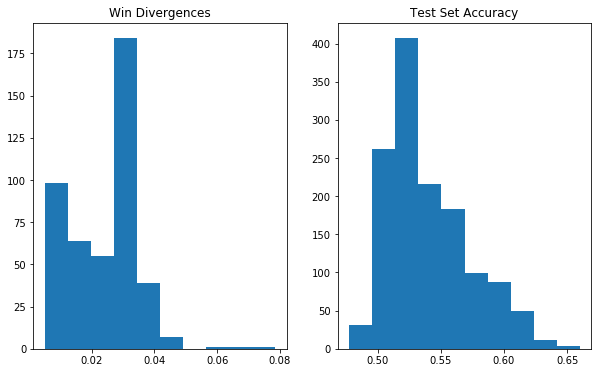

In [220]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.hist([x[1] for x in mean_win_div])
plt.title('Win Divergences')

plt.subplot(122)
plt.hist([x[1] for x in test_acc])
plt.title('Test Set Accuracy')
plt.show()

## hdbscan knn testing

In [77]:
test = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(bsps['Top'][thresh_1_feats['Top']])
probs = hdbscan.all_points_membership_vectors(test)
probs[:5]

array([[ 0.35237966,  0.64762034],
       [ 0.41360412,  0.58639588],
       [ 0.37513089,  0.62486911],
       [ 0.38440939,  0.61559061],
       [ 0.38695451,  0.61304549]])

In [175]:
lab_test = hdbscan_with_knn(bsps['Top'][thresh_1_feats['Top']],hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=False))

In [178]:
np.unique(test.labels_, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([1193,   11, 7816], dtype=int64))

In [177]:
lab_test.value_counts()

 1    8316
-1     680
 0      24
Name: label, dtype: int64

## Questions / Next Steps

- How to handle meanshift tuning
- How to weight classifier accuracy against win predictions
- Any experience making a a keras generator for multiple hdf5 files?

In [152]:
test_scores

{'kmeans_2': {'Auto_features_1': {'kc': {'AUC_test': 0.54044701998514921,
    'AUC_train': 0.62018107313995463,
    'accuracy_test': 0.52069475249017683,
    'accuracy_train': 0.55448210327203118,
    'log_loss_test': 0.72229930471851922,
    'log_loss_train': 0.68519093689801081,
    'test': {},
    'train': {}},
   'rf': {'AUC_test': 0.53400048846880332,
    'AUC_train': 0.583228454356298,
    'accuracy_test': 0.52439024390243905,
    'accuracy_train': 0.55844155844155841,
    'log_loss_test': 0.69304761009587112,
    'log_loss_train': 0.68306311552376087,
    'test': {},
    'train': {}},
   'tr': {'AUC_test': 0.51829217318896359,
    'AUC_train': 0.57961561064749634,
    'accuracy_test': 0.51330376940133038,
    'accuracy_train': 0.55669939816281278,
    'log_loss_test': 0.70007927806595904,
    'log_loss_train': 0.68232098184784074,
    'test': {},
    'train': {}},
   'win_div': [0.027050997782705123,
    0.017184035476718373,
    0.019179600886917947,
    0.007760532150776088,
 

GTC gpu tech conferrence

### Meeting Notes:
- Lots of approaches to parameter tune, no perfect method, just need to find w/e gives strongest signal
- Try multiple classifiers seperately and together
- 